# Predictive Modelling - Binary Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from time import perf_counter
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    TunedThresholdClassifierCV,
    StratifiedKFold,
    LearningCurveDisplay,
    cross_validate,
    train_test_split,
    cross_val_predict
)
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform

sns.set(color_codes=True)
%matplotlib inline

SEED = 1

In [2]:
df = pd.read_csv("Assignment_Data.csv")
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


## Data Claning and Exploratory Analysis

In [3]:
df.isnull().sum()

patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64

As can be seen above, there are no null values in the dataset.

In [4]:
print(f"The number of patients is {df.patient_id.nunique()}")

The number of patients is 200


All the rows have unique patient IDs so there are no duplicated values. There are in total 200 rows in the dataset. 

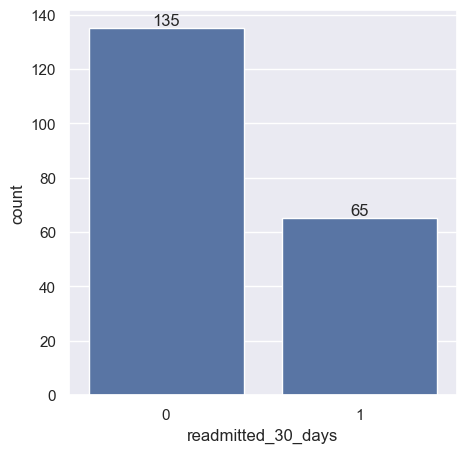

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='readmitted_30_days', data=df, ax=ax)
ax.bar_label(ax.containers[0]);

The number of patients that are readdmited to the hospital within 30 days is approximately half of the number of patients that are not readmitted. This is not an highly unbalanced dataset but the size of the dataset is very small. 

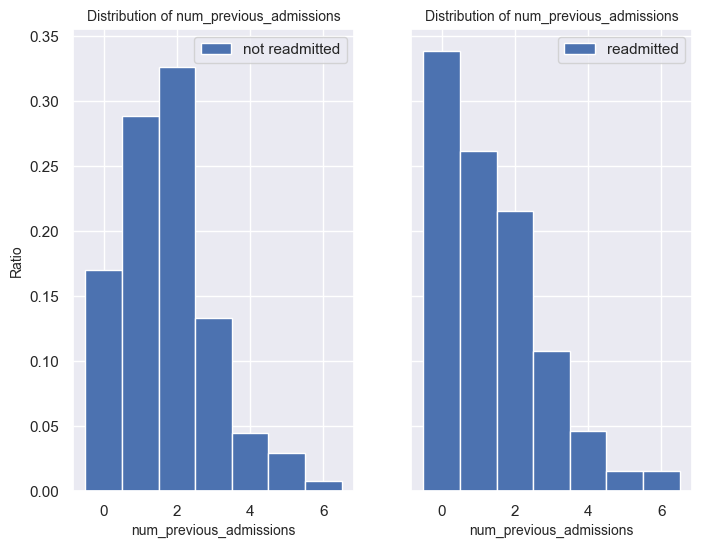

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

df[df["readmitted_30_days"] == 0]["num_previous_admissions"].plot(kind="hist", ax=axes[0], density=True, bins=np.arange(min(df["num_previous_admissions"]) - 0.5, max(df["num_previous_admissions"]) + 0.5 + 1), label="not readmitted")
axes[0].set_title("Distribution of num_previous_admissions", fontsize=10)
axes[0].set_ylabel("Ratio", fontsize=10)
axes[0].set_xlabel("num_previous_admissions", fontsize=10)
axes[0].legend()
df[df["readmitted_30_days"] == 1]["num_previous_admissions"].plot(kind="hist", ax=axes[1], density=True, bins=np.arange(min(df["num_previous_admissions"]) - 0.5, max(df["num_previous_admissions"]) + 0.5 + 1), label="readmitted")
axes[1].set_title("Distribution of num_previous_admissions", fontsize=10)
axes[1].set_xlabel("num_previous_admissions", fontsize=10)
axes[1].legend()
plt.show()

When the distributions of the number of previous admissions are studied, it seems that the patiens that were not admitted to the hospital before the current admission are more likley to be readmitted within 30 days.

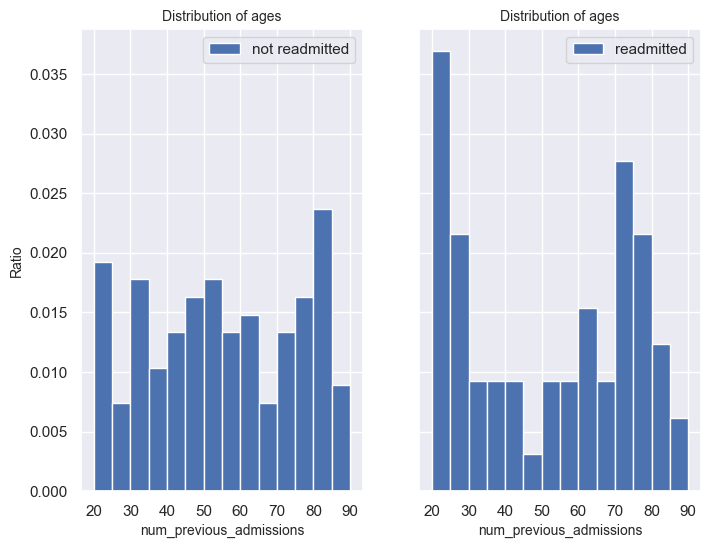

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

df[df["readmitted_30_days"] == 0]["age"].plot(kind="hist", ax=axes[0], density=True, bins=np.arange(20, 91, 5), label="not readmitted")
axes[0].set_title("Distribution of ages", fontsize=10)
axes[0].set_ylabel("Ratio", fontsize=10)
axes[0].set_xlabel("num_previous_admissions", fontsize=10)
axes[0].set_xticks(range(20,91,10))
axes[0].legend()
df[df["readmitted_30_days"] == 1]["age"].plot(kind="hist", ax=axes[1], density=True, bins=np.arange(20, 91, 5), label="readmitted")
axes[1].set_title("Distribution of ages", fontsize=10)
axes[1].set_xlabel("num_previous_admissions", fontsize=10)
axes[1].set_xticks(range(20,91,10))
axes[1].legend()
plt.show()

When the two distributions above are studied, it seems like the patients that have ages between 20 and 30 or between 70 and 80 are more like to be readmitted. 

In [8]:
pd.crosstab(index=df.gender, columns=df.readmitted_30_days, normalize="index")

readmitted_30_days,0,1
gender,,
Female,0.691589,0.308411
Male,0.655914,0.344086


From the table above, it seems like male readmission rate is higher but the number of sampling size is very low. Chi-square test can be run to see if gender has an effect on readmission. 

In [9]:
df.diagnosis_code.unique()

array(['D002', 'D001', 'D004', 'D003'], dtype=object)

There are 4 types of diagnosis codes as seen above.

In [10]:
pd.crosstab(index=df.diagnosis_code, columns=df.readmitted_30_days, normalize="index")

readmitted_30_days,0,1
diagnosis_code,,
D001,0.660714,0.339286
D002,0.722222,0.277778
D003,0.621622,0.378378
D004,0.679245,0.320755


It seems like the readmission rate for the diagnosis __D003__ is higher compared to the others.

In [11]:
df.medication_type.unique()

array(['Type C', 'Type B', 'Type A'], dtype=object)

In [12]:
pd.crosstab(index=df.medication_type, columns=df.readmitted_30_days, normalize="index")

readmitted_30_days,0,1
medication_type,,
Type A,0.731343,0.268657
Type B,0.652174,0.347826
Type C,0.640625,0.359375


Compared to Type B and C, patients treated with medication Type A seem to be readmitted less frequently. 

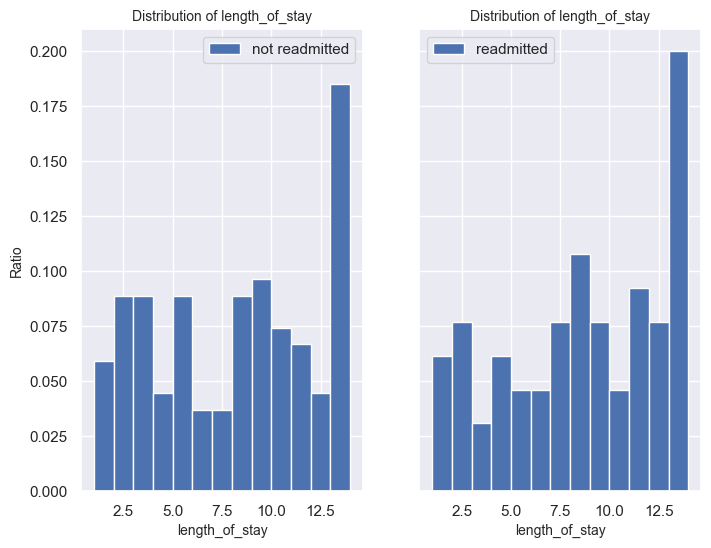

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

df[df["readmitted_30_days"] == 0]["length_of_stay"].plot(kind="hist", ax=axes[0], density=True, bins=np.arange(min(df["length_of_stay"]), max(df["length_of_stay"]) + 1), label="not readmitted")
axes[0].set_title("Distribution of length_of_stay", fontsize=10)
axes[0].set_ylabel("Ratio", fontsize=10)
axes[0].set_xlabel("length_of_stay", fontsize=10)
axes[0].legend()
df[df["readmitted_30_days"] == 1]["length_of_stay"].plot(kind="hist", ax=axes[1], density=True, bins=np.arange(min(df["length_of_stay"]), max(df["length_of_stay"]) + 1), label="readmitted")
axes[1].set_title("Distribution of length_of_stay", fontsize=10)
axes[1].set_xlabel("length_of_stay", fontsize=10)
axes[1].legend()
plt.show()

There does not seem to be major differences between the length of stay distributions for the readmitted and not readmitted patients.

One thing to keep in mind is that, all the features are analysed individually above. There can be interactions between the features that affect the outcome (a patient being readmitted or not). Deep learning models are ideal for learning these interactions but the amount of data here is very low for training a complex model. 

## Preprocessing and Training

In [14]:
x_train = df.drop(columns=["patient_id", "readmitted_30_days", "discharge_note"])
y_train = df["readmitted_30_days"]

In [15]:
ct = ColumnTransformer(
    transformers=[
        ("scaling", StandardScaler(), ["age", "num_previous_admissions", "length_of_stay"]),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"), ["gender", "diagnosis_code", "medication_type"]),
    ]
)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

In [16]:
dummy_clf = DummyClassifier(strategy="stratified")

scores = cross_validate(dummy_clf, x_train, y_train, cv=kfold, scoring={'log_loss': 'neg_log_loss', 'AUC': 'roc_auc', 'AP': 'average_precision', 'f1': 'f1'})

In [17]:
print(f"Validation log loss: {-np.mean(scores['test_log_loss']):.3f}")
print(f"Validation AUC: {np.mean(scores['test_AUC']):.3f}")
print(f"Validation AP: {np.mean(scores['test_AP']):.3f}")
print(f"Validation F1-Score: {np.mean(scores['test_f1']):.3f}")

Validation log loss: 16.400
Validation AUC: 0.456
Validation AP: 0.330
Validation F1-Score: 0.187


In [18]:
lr = LogisticRegression(solver="lbfgs", penalty="l2", max_iter=10000)

pipe_lr = Pipeline(steps=[("CT", ct), ("LR", lr)])

distributions = {"LR__C": loguniform(1e-5, 1e3)}

lr_classifier = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=distributions,
    n_iter=1000,
    scoring=["neg_log_loss", "roc_auc", "average_precision"],
    return_train_score=True,
    refit="average_precision",
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=SEED,
)

t1_start = perf_counter()
lr_classifier.fit(x_train, y_train)
t1_stop = perf_counter()

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


In [19]:
print(f"Time needed for training: {(t1_stop - t1_start)/60:.2f} minutes")
print(f"Parameters that maximizes the AP for the validation data:\n{lr_classifier.best_params_}\n")
index = lr_classifier.cv_results_["mean_test_average_precision"].argmax()
print(f"AP for the training data: {lr_classifier.cv_results_['mean_train_average_precision'][index]:.3f}")
print(f"AP for the validation data: {lr_classifier.best_score_:.3f}")
print(f"Log Loss on training data: {-lr_classifier.cv_results_['mean_train_neg_log_loss'][index]:.3f}")
print(f"Log Loss on validation data: {-lr_classifier.cv_results_['mean_test_neg_log_loss'][index]:.3f}")
print(f"AUC on training data: {lr_classifier.cv_results_['mean_train_roc_auc'][index]:.3f}")
print(f"AUC on validation data: {lr_classifier.cv_results_['mean_test_roc_auc'][index]:.3f}")

Time needed for training: 0.34 minutes
Parameters that maximizes the AP for the validation data:
{'LR__C': 0.00014929564057609773}

AP for the training data: 0.440
AP for the validation data: 0.444
Log Loss on training data: 0.630
Log Loss on validation data: 0.631
AUC on training data: 0.616
AUC on validation data: 0.550


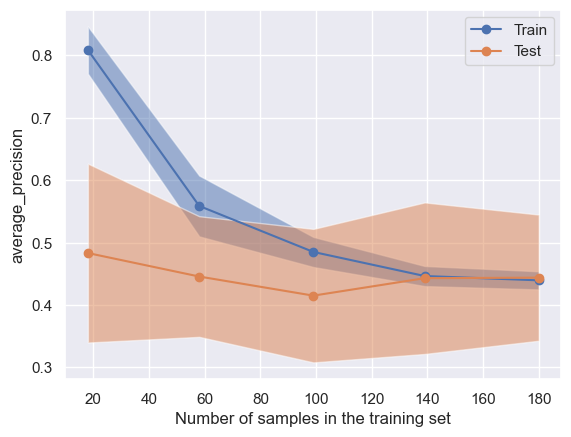

In [20]:
LearningCurveDisplay.from_estimator(lr_classifier.best_estimator_, x_train, y_train, 
    cv= kfold,
    n_jobs= -1,
    line_kw= {"marker": "o"},
    scoring= "average_precision",
    score_name = "average_precision",
    negate_score=False)
plt.show()

In [21]:
classifier_tuned = TunedThresholdClassifierCV(lr_classifier.best_estimator_, scoring="balanced_accuracy", cv=kfold).fit(x_train, y_train)
print(f"Cut-off point found at {classifier_tuned.best_threshold_:.3f}")

Cut-off point found at 0.322


In [22]:
scores = cross_validate(classifier_tuned, x_train, y_train, cv=kfold, scoring={'F1-score': 'f1'})

In [23]:
print(f"Validation F1: {np.mean(scores['test_F1-score']):.3f}")

Validation F1: 0.390


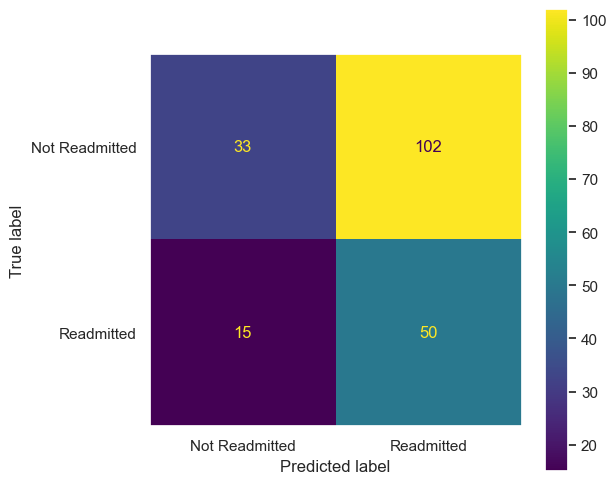

In [24]:
y_pred = cross_val_predict(classifier_tuned, x_train, y_train, cv=kfold)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, labels=[0, 1], display_labels=["Not Readmitted","Readmitted"], ax=ax)
ax.grid(False)

In [25]:
f1_score(y_train, np.ones(len(y_train)))

0.49056603773584906

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=SEED)

classifier_tuned.fit(x_train, y_train)

scoring = ["average_precision"]

r = permutation_importance(classifier_tuned, x_val, y_val, n_repeats=30, random_state=SEED, scoring=scoring, n_jobs=-1)

In [27]:
for metric in r:
    print(f"{metric}")
    print("-"*23)
    for i in r[metric].importances_mean.argsort()[::-1]:
        print(f"{x_val.columns[i]:<25}"
        f"{r[metric].importances_mean[i]:.5f}"
        f" +/- {r[metric].importances_std[i]:.5f}")
    print()

average_precision
-----------------------
age                      0.08380 +/- 0.04578
length_of_stay           0.06336 +/- 0.05368
medication_type          0.01709 +/- 0.02856
diagnosis_code           0.01497 +/- 0.02573
gender                   -0.00532 +/- 0.03246
num_previous_admissions  -0.03672 +/- 0.10920



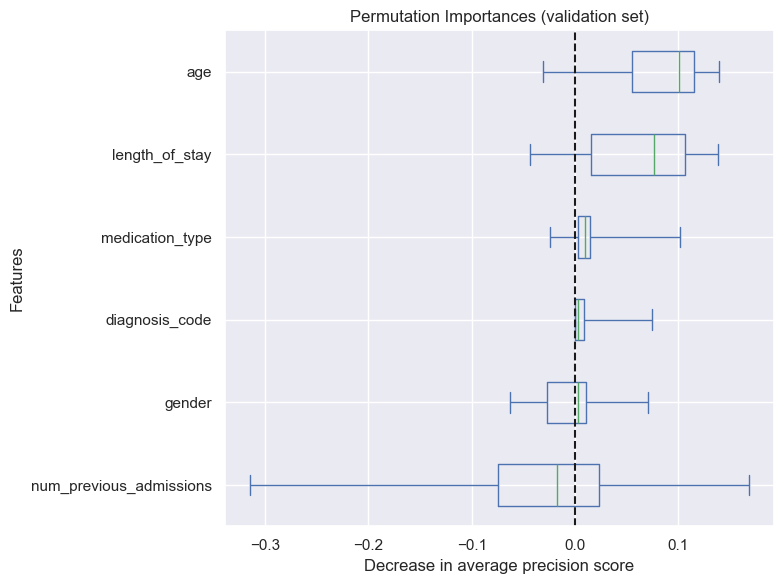

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
sorted_importances_idx = r["average_precision"].importances_mean.argsort()
importances = pd.DataFrame(
    r["average_precision"].importances[sorted_importances_idx].T,
    columns=x_val.columns[sorted_importances_idx],
)

importances.plot.box(vert=False, whis=10, ax=ax)
ax.set_title("Permutation Importances (validation set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in average precision score")
ax.set_ylabel("Features")
ax.figure.tight_layout()

# Named Entity Recognition from Discharge Notes (LLM/NLP)

In [29]:
import stanza

In [30]:
stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = stanza.Pipeline('en', package='mimic', processors={'ner': 'i2b2'})

2025-06-15 15:14:37 INFO: Downloaded file to /Users/coskudeniz/stanza_resources/resources.json
2025-06-15 15:14:37 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| forward_charlm  | mimic          |
| pretrain        | mimic          |
| backward_charlm | mimic          |

2025-06-15 15:14:37 INFO: File exists: /Users/coskudeniz/stanza_resources/en/tokenize/mimic.pt
2025-06-15 15:14:37 INFO: File exists: /Users/coskudeniz/stanza_resources/en/pos/mimic_charlm.pt
2025-06-15 15:14:37 INFO: File exists: /Users/coskudeniz/stanza_resources/en/lemma/mimic_nocharlm.pt
2025-06-15 15:14:38 INFO: File exists: /Users/coskudeniz/stanza_resources/en/depparse/mimic_charlm.pt
2025-06-15 15:14:38 INFO: File exists: /Users

2025-06-15 15:14:38 INFO: Downloaded file to /Users/coskudeniz/stanza_resources/resources.json
2025-06-15 15:14:39 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | i2b2           |

2025-06-15 15:14:39 INFO: Using device: cpu
2025-06-15 15:14:39 INFO: Loading: tokenize
2025-06-15 15:14:41 INFO: Loading: pos
2025-06-15 15:14:42 INFO: Loading: lemma
2025-06-15 15:14:42 INFO: Loading: depparse
2025-06-15 15:14:42 INFO: Loading: ner
2025-06-15 15:14:43 INFO: Done loading processors!


In [31]:
results = []

for text in df.discharge_note:
    doc = nlp(text)
    # print out all entities
    entities = []
    for ent in doc.entities:
        entities.append((ent.text,ent.type))
    results.append(entities)

In [32]:
df["clinical_entities"] = results

In [33]:
df.head(10)

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note,clinical_entities
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...,"[(Follow-up scan, TEST)]"
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...,[]
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...,"[(Symptoms, PROBLEM), (relapse, PROBLEM)]"
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...,[]
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...,[]
5,6,22,Female,D004,1,Type A,10,1,Good recovery trajectory. Follow-up scan sched...,"[(Follow-up scan, TEST)]"
6,7,41,Male,D002,1,Type A,7,1,Discharge after recovery from pneumonia. No co...,"[(pneumonia, PROBLEM), (complications, PROBLEM)]"
7,8,72,Male,D002,0,Type B,7,1,Patient discharged in stable condition. Recomm...,[]
8,9,21,Female,D003,4,Type B,12,0,Patient showed improvement. Prescribed antibio...,"[(antibiotics, TREATMENT)]"
9,10,49,Male,D002,2,Type A,7,0,Blood pressure under control. Continue current...,"[(Blood pressure, TEST), (current medication, ..."


In [34]:
set([ent[1] for entities in results for ent in entities])

{'PROBLEM', 'TEST', 'TREATMENT'}